# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [5]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[ 1.421321   -1.8786187  -0.8995674  ... -0.42085493  1.311429
  -0.32077324]
 [ 0.691849    0.8121028  -1.0744771  ...  1.3934727   0.0129213
  -0.34083116]
 [ 0.1416647  -0.17275469 -1.4112434  ...  0.35133076  0.41363308
   0.15098007]
 ...
 [ 0.08257849 -1.1038202  -0.59112495 ... -0.43097895 -1.3222116
   2.472127  ]
 [ 0.03014897  0.8690315  -1.356235   ... -1.7580678  -1.8674766
  -0.30607346]
 [ 0.5874972   0.08267537 -0.500262   ...  0.39317173  0.15333314
   0.8129531 ]]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


* Initialization of weights

In [35]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1,n_h2).astype(np.float32),name="w2")
w3= tf.Variable(1e-3*np.random.randn(n_h2,n_y).astype(np.float32),name="w3")

* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [48]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    
    ## 코드를 작성해 보세요 ##
    z2=tf.matmul(a1, w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2, w3)
    predictions = tf.nn.sigmoid(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [49]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    ## 코드를 작성해 보세요 ## (hint: tape.gradient를 구글링 해보세요)
    gradient = tape.gradient(loss, [w1, w2])
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2]))
    return loss, w1, w2


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [50]:
loss_list = []

for step in range(10): 
    loss, w1, w2 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

[347.23193, 347.07233, 346.935, 346.81757, 346.71555, 346.626, 346.54596, 346.47293, 346.40924, 346.35336]


# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [51]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

11493376/11490434 [==============================] - 0s 0us/step


## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [52]:
x_train.shape 

(60000, 28, 28)

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [53]:
x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

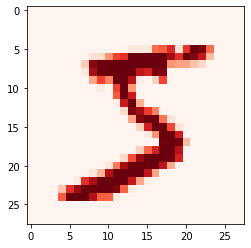

In [62]:
plt.imshow(x_train[0].reshape(28,28)).set_cmap('Reds')

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [63]:
y_train.shape

(60000,)

In [64]:
# show MNIST label for above data
y_train[0]

5

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [65]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [106]:
#### 자유롭게 Model을 만들고 compile 해봅시다 ####
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation= 'relu', input_shape=(784,)))
model.add(layers.Dense(32, activation='relu'))                                                            
model.add(layers.Dense(10, activation='softmax'))

from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

내가 만든 모델을 확인해 봅시다.

In [107]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_54 (Dense)             (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


model을 자유롭게 train 해봅시다.  

In [108]:
model.fit(x_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 0s 1ms/step - loss: 0.4956 - accuracy: 0.8651
Epoch 2/10
469/469 [==============================] - 0s 1ms/step - loss: 0.2211 - accuracy: 0.9358
Epoch 3/10
469/469 [==============================] - 0s 1ms/step - loss: 0.1772 - accuracy: 0.9481
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1508 - accuracy: 0.9557
Epoch 5/10
469/469 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.9614
Epoch 6/10
469/469 [==============================] - 0s 1ms/step - loss: 0.1184 - accuracy: 0.9653
Epoch 7/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1080 - accuracy: 0.9680
Epoch 8/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0995 - accuracy: 0.9701
Epoch 9/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0919 - accuracy: 0.9727
Epoch 10/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0865 - accuracy: 0.9740

95%이상의 성능을 가진 모델을 만들면 완성!

In [109]:
test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print('\nAccuracy:', test_acc)

313/313 - 0s - loss: 0.1110 - accuracy: 0.9675

Accuracy: 0.9674999713897705


![](https://www.tensorflow.org/versions/master/images/mnist_tensorboard.png)